### Imports

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
# Common torch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# VAE related
import torchvision
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
# Image/plotting libraries
import math
import matplotlib.pyplot as plt
from PIL import Image
if COLAB:
    !pip install ipyplot
import ipyplot
# Utilities
from tqdm import tqdm
import pdb
# Fix rng
seed = 666
torch.manual_seed(seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.7 MB/s eta 0:00:00

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


### Data

In [3]:
def load_mnist(subset=None, lengths=None):
    transform = torchvision.transforms.ToTensor()
    mnist_data = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
    if subset is not None:
        print(f"Using subset")
        mnist_data = torch.utils.data.Subset(mnist_data, subset)
    elif lengths is not None:
        print(f"Using random split of {lengths}")
        mnist_data,_ = torch.utils.data.random_split(mnist_data, lengths)
    return mnist_data

# Checking counts of each digit in dataset
def digit_counts(dataset):
    labels = [dataset.__getitem__(i)[1] for i in range(len(dataset))]
    counts = []
    for i in range(10):
        counts.append(labels.count(i))
    plt.plot(counts)
    return counts

# Display examples
def show_examples(dataset, n=10):
    exs = []
    for i in range(n):
        ex,label = dataset.__getitem__(i) # Get first image
        print(f"Image label = {label}")
        ex = tensor_to_pil(ex) # Create batch dimension, convert to PIL
        ex = ex.resize((100,100), Image.NEAREST)
        display(ex)
        exs.append(ex)
    return exs

# Get mean and std of training set
def normalize_data(loader):
    pixels = []
    for (x,y) in loader:
        pixels.append(x)
    pixels = torch.cat(pixels, dim=0)
    return torch.mean(pixels),torch.std(pixels)

### ffcv

In [5]:
if not COLAB:
    !apt update && apt install -y --no-install-recommends libopencv-dev libturbojpeg-dev
    !cp -f /usr/lib/x86_64-linux-gnu/pkgconfig/opencv.pc /usr/lib/x86_64-linux-gnu/pkgconfig/opencv4.pc
    !pip install ffcv numba opencv-python
    # ffcv writer
    import ffcv
    from ffcv.writer import DatasetWriter
    from ffcv.fields import NDArrayField, TorchTensorField, IntField
    # ffcv loader
    from ffcv.fields.decoders import NDArrayDecoder, IntDecoder
    from ffcv.transforms import ToTensor, ToDevice, Convert, Squeeze
    from ffcv.loader import Loader, OrderOption

import os

class MNIST_WRAPPER(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img,label = self.dataset.__getitem__(idx)
        img = img.numpy()
        img = img.flatten()
        return img,label

def write_dataset(dataset):
    dataset = MNIST_WRAPPER(dataset)
    path = f'./MNIST/ffcv/subset_{len(dataset)}.beton'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    writer = DatasetWriter(
        path,
        {
            'image': NDArrayField(shape=(784,), dtype=np.dtype('float32')),
            'label': IntField()
        },
        num_workers=4
    )
    writer.from_indexed_dataset(dataset)
    print(f"MNIST subset of length {len(dataset)} written to .beton.")
    return path

def ffcv_loader(path, device, batch_size, num_workers, reduce_precision=False):
    PIPELINES = {
        'image':
            [NDArrayDecoder(),
            ToTensor(),
            ToDevice(device),
            ],
        'label':
            [IntDecoder(),
            ToTensor(),
            ToDevice(device),
            Squeeze()
            ]
    }
    loader = Loader(
        path,
        batch_size=batch_size,
        num_workers=num_workers,
        order=OrderOption.RANDOM,
        pipelines=PIPELINES,
        drop_last=False,
        batches_ahead=3,
    )
    return loader

### Model

In [6]:
def tensor_to_pil(x):
    with torch.no_grad():
        x = torch.reshape(x, (28,28))
        # Clip and scale back to 0-255
        x = torch.clip(x, min=0.0, max=1.0)
        x *= 255
        x = x.detach().cpu()
        x = np.uint8(x)
        x = Image.fromarray(x, mode='L')
    return x

def reconstruct(enc,dec,dataset,idxs,mean_data,std_data):
    enc.eval()
    dec.eval()
    reconstrs = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for idx in idxs:
            # Load image / flatten
            x,y = dataset.__getitem__(idx)
            x = torch.flatten((x - mean_data)/std_data, start_dim=1).to(device)
            # Forward pass w/o noise
            mean_z, var_z = enc(x)
            mean_x, var_x = dec(mean_z)
            # Convert back to PIL
            x = tensor_to_pil(x*std_data + mean_data)
            x_hat = tensor_to_pil(mean_x*std_data + mean_data)
            reconstrs.append((x,x_hat))
        # Display side-by-side
        fuseds = []
        for x,x_hat in reconstrs:
            fused = Image.new('L', (x.width+x_hat.width, x.height))
            fused.paste(x, (0,0))
            fused.paste(x_hat, (x.width,0))
            fuseds.append(fused.resize((2*100,100), resample=Image.NEAREST))
    ipyplot.plot_images(fuseds, max_images=100, img_width=28*4)
    enc.train()
    dec.train()
    return reconstrs


In [7]:
class Encoder(nn.Module):
    def __init__(self, dim, mean, std):
        super().__init__()
        self.dim = dim
        self.mean = mean
        self.std = std
        self.net = nn.Sequential(
            nn.Linear(dim['x'],dim['h']),
            nn.ReLU(),
            nn.Linear(dim['h'], dim['z']*2)
        )
    def forward(self,x):
        phi = self.net(x)
        mean_z, var_z = torch.split(phi, [self.dim['z'],self.dim['z']], dim=-1)
        assert mean_z.shape==var_z.shape
        var_z = torch.exp(var_z)
        return mean_z, var_z

class Decoder(nn.Module):
    def __init__(self, dim, mean, std):
        super().__init__()
        self.dim = dim
        self.mean = mean
        self.std = std
        self.net = nn.Sequential(
            nn.Linear(dim['z'],dim['h']),
            nn.ReLU(),
            nn.Linear(dim['h'],dim['x']+1)
        )
    def forward(self,z):
        theta = self.net(z)
        mean_x, var_x = torch.split(theta, [self.dim['x'],1], dim=-1)
        var_x = torch.exp(var_x)
        return mean_x, var_x

def create_model(dim, mean, std):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    enc = Encoder(dim, mean, std).to(device)
    dec = Decoder(dim, mean, std).to(device)
    return enc,dec


In [8]:
# Returns negative of KL(q_phi(z|x), p(z))
def get_KL(mu,var):
    mu_2 = torch.square(mu)
    inner = 1.0 + torch.log(var) - mu_2 - var
    summed = torch.sum(inner, dim=1)
    return -0.5*summed

def forward_pass(x,enc,dec,dim,device,beta=1.0):
    # Encode, inject noise, decode
    mean_z, var_z = enc(x)
    eps = torch.normal(mean=0.0, std=1.0, size=(dim['l'], x.shape[0], dim['z']), device=device)
    z = mean_z[None,:,:] + torch.sqrt(var_z[None,:,:])*eps
    mean_x, var_x = dec(z)

    # Average log-likelihoods over minibatch
    var_x = var_x.expand(mean_x.shape)
    normals = MultivariateNormal(mean_x, torch.diag_embed(var_x))
    log_likelhds = normals.log_prob(x[None,:,:])
    log_likelhds = torch.mean(log_likelhds, dim=0)

    # Get closed-form KL divergence and ELBO
    KL = get_KL(mean_z, var_z)
    ELBO = torch.sum(log_likelhds - beta*KL) * dim['N'] / dim['M']
    return -1.0*ELBO, KL


### Train

In [13]:
dim = {
    'x':784, # observation dimensionality, 2 for circle data and 784 for MNIST
    'h':500, # hidden layer units
    'z':2, # latent space dimensionality
    'l':1, # number of z samples per x
    'N':20000, # dataset size
    'M':100, # batch size
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ffcv = not COLAB
anneal = False

# Create dataset + dataloader
dataset = load_mnist(subset=list(range(dim['N'])))
loader = DataLoader(dataset, batch_size=dim['M'], shuffle=True, num_workers=0, drop_last=False, pin_memory=True)
mean_data, std_data = normalize_data(loader)
if ffcv:
    print("Writing .beton files...")
    path = write_dataset(dataset)
    loader = ffcv_loader(path, device, dim['M'], 4, reduce_precision=False)

# Create model
enc,dec = create_model(dim, mean_data, std_data)
optim = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()),
                           lr=0.001, weight_decay=0.0)

# Hardcode the cyclic annealing and number of epochs
betas = []
epoch_losses = []
KLs = []
if anneal:
    c = 0
    num_cycles = 3
    epochs_per_cycle = 30
    iter_per_epoch = len(loader)
    beta_growth_rate = 2 / (epochs_per_cycle * iter_per_epoch) # denominator
    num_epochs = epochs_per_cycle*num_cycles
else:
    num_epochs = 60
    epochs_per_cycle = 20


Using subset


In [14]:
enc.train()
dec.train()

start_epoch = 0
torch.cuda.empty_cache()

  0%|          | 0/60 [00:00<?, ?it/s]


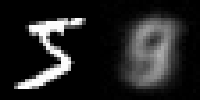
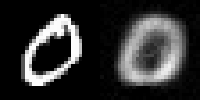
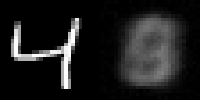
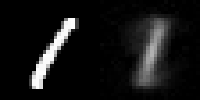
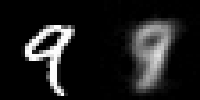
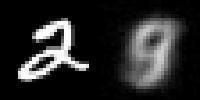
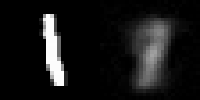
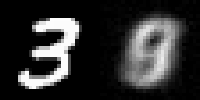
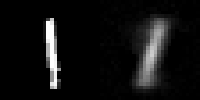
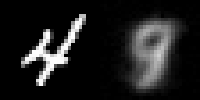


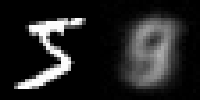
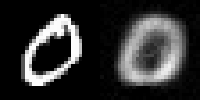
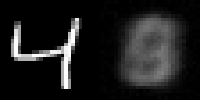
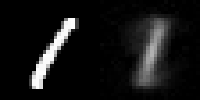
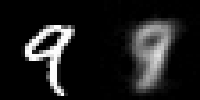
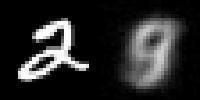
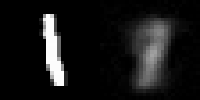
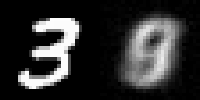
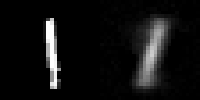
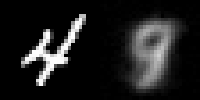


  8%|▊         | 5/60 [04:00<44:02, 48.04s/it]


KeyboardInterrupt: ignored

In [16]:
for epoch in tqdm(range(start_epoch,start_epoch+num_epochs)):
    # Start new cycle / show current loss and reconstructions
    if epoch%epochs_per_cycle==0:
        _ = reconstruct(enc,dec,dataset,list(range(10)),mean_data,std_data)
        if anneal:
            c = 0
            plt.plot(betas)
            plt.pause(0.05)
    # One epoch:
    epoch_loss = 0.0
    epoch_KL = 0.0
    for i,(x,y) in enumerate(tqdm(loader)):
        x = (torch.flatten((x - mean_data)/std_data, start_dim=1))
        if not ffcv:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

        # cyclic annealing - beta
        beta = 1.0
        if anneal:
            beta = min(1.0, c * beta_growth_rate) # Levels off at beta=1.0
            c += 1
        betas.append(beta)

        # Backprop thru ELBO
        optim.zero_grad()
        loss,KL = forward_pass(x,enc,dec,dim,device,beta)
        loss.backward()
        optim.step()
        loss = loss.detach().clone().cpu().item()
        epoch_loss += loss*x.shape[0]

    # Track epoch losses
    epoch_loss = epoch_loss / len(dataset)
    epoch_losses.append(epoch_loss)
    # Save checkpoint
    if (epoch+1)%epochs_per_cycle==0:
        torch.save(enc, f"enc_{int(dim['N']/1000)}k_{epoch+1}.pt")
        torch.save(dec, f"dec_{int(dim['N']/1000)}k_{epoch+1}.pt")


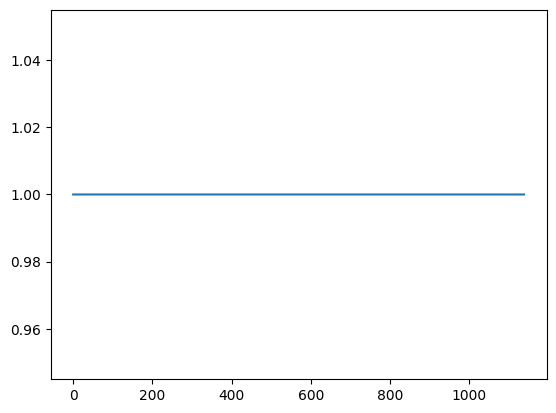

In [17]:
plt.plot(betas)

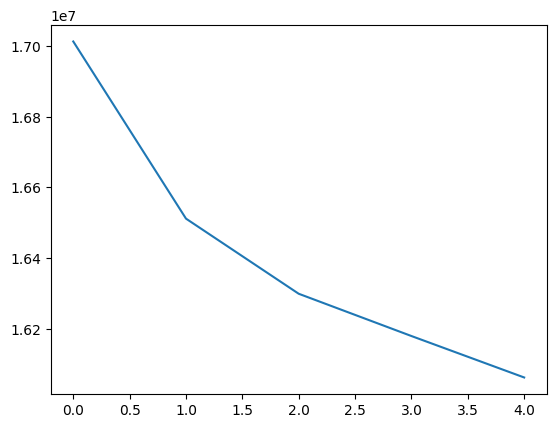

In [18]:
plt.plot(epoch_losses)

### Visualize

In [19]:
# Samples from prior and decodes
def sample_prior(n,dec,mean_data,std_data,device,k=2,as_grid=True, color='black'):
    z = torch.normal(mean=0.0, std=1.0, size=(n,dim['z']), device=device)
    dec.eval()
    with torch.no_grad():
        mean_x, var_x = dec(z)
        imgs = [tensor_to_pil((x*std_data + mean_data)) for x in mean_x]
        imgs = [img.resize((28*k,28*k), resample=Image.NEAREST) for img in imgs]
    if as_grid and (n**0.5==int(n**0.5)):
        fig,axes = plt.subplots(nrows=int(n**0.5),ncols=int(n**0.5), figsize=(12,12))
        for i,ax in enumerate(axes.flat):
            ax.imshow(imgs[i], cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        # Plot cosmetic changes
        fig.suptitle("Decoded samples from prior", fontsize=25, color=color)
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        fig.subplots_adjust(wspace=0.1,hspace=0.1)
    else:
        ipyplot.plot_images(imgs, max_images=1000, img_width=28*k)
    return imgs

In [20]:
def interpolate(dec, dim, device, probs=None, WH=None, steps=(9,9), color='black'):
    fig,axes = plt.subplots(nrows=steps[1],ncols=steps[0], figsize=(12,12))
    imgs = []
    if probs is not None:
        # Inverse cdf to get representative latent values for every probability mass increment
        probs_x = torch.linspace(probs[0],probs[1],steps[0])
        probs_y = torch.linspace(probs[0],probs[1],steps[1])
        normal = Normal(loc=0.0, scale=1.0)
        z1 = normal.icdf(probs_x)
        z2 = normal.icdf(probs_y)
        fig.suptitle("Latent space interpolation - icdf", fontsize=30, color=color)
        print("Using icdf.")
    elif WH is not None:
        # Equal-sized steps through latent space
        W,H = WH
        z1 = torch.linspace(-W,W,steps[0])
        z2 = torch.linspace(-H,H,steps[1])
        fig.suptitle("Latent space interpolation - linear", fontsize=30, color=color)
        print("Using linear steps.")
    print(f"z1 range = ({z1.min()},{z1.max()}) ")
    print(f"z2 range = ({z2.min()},{z2.max()}) ")
    # Loop over grid and generate images
    for i in tqdm(range(len(z1))):
        for j in range(len(z2)):
            ax = axes[steps[1]-j-1][i]
            # Decode latent value
            z = torch.stack([z1[i],z2[j]],dim=0).to(device)
            mean_x, var_x = dec(z[None,:])
            img = tensor_to_pil(mean_x)
            ax.imshow(img, cmap='gray')
            # Clean up plot
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # Verify x,y increasing to upper-right:
            # ax.set_title(str(np.round(z.cpu().numpy(), decimals=1)))
            # Store image
            imgs.append(img)
    # Plot cosmetic changes
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.subplots_adjust(wspace=0.1,hspace=0.1)
    return imgs


In [21]:
def latent_vis(enc, loader, device, mean_data, std_data, ffcv=False, color='black'):
    enc.eval()
    with torch.no_grad():
        latents = []
        labels = []
        for (x,y) in loader:
            # Encode
            x = (torch.flatten((x - mean_data)/std_data, start_dim=1))
            if not ffcv:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
            mean_z,var_z = enc(x)
            # Store latent and labels
            latents.append(mean_z)
            labels.append(y.clone().tolist())
        latents = torch.cat(latents, dim=0).cpu().numpy()

        # Plot
        fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(12,12))
        cmap = plt.get_cmap('Spectral')
        scatter = ax.scatter(latents[:,0],latents[:,1], s=0.1,c=labels,cmap=cmap)
        legend = ax.legend(*scatter.legend_elements(),
                        loc="lower right", title="Classes",prop={'size': 20},markerscale=4)
        ax.add_artist(legend)
        ax.set_title("Latent space encodings of MNIST training set",fontsize=20, color=color)
    return


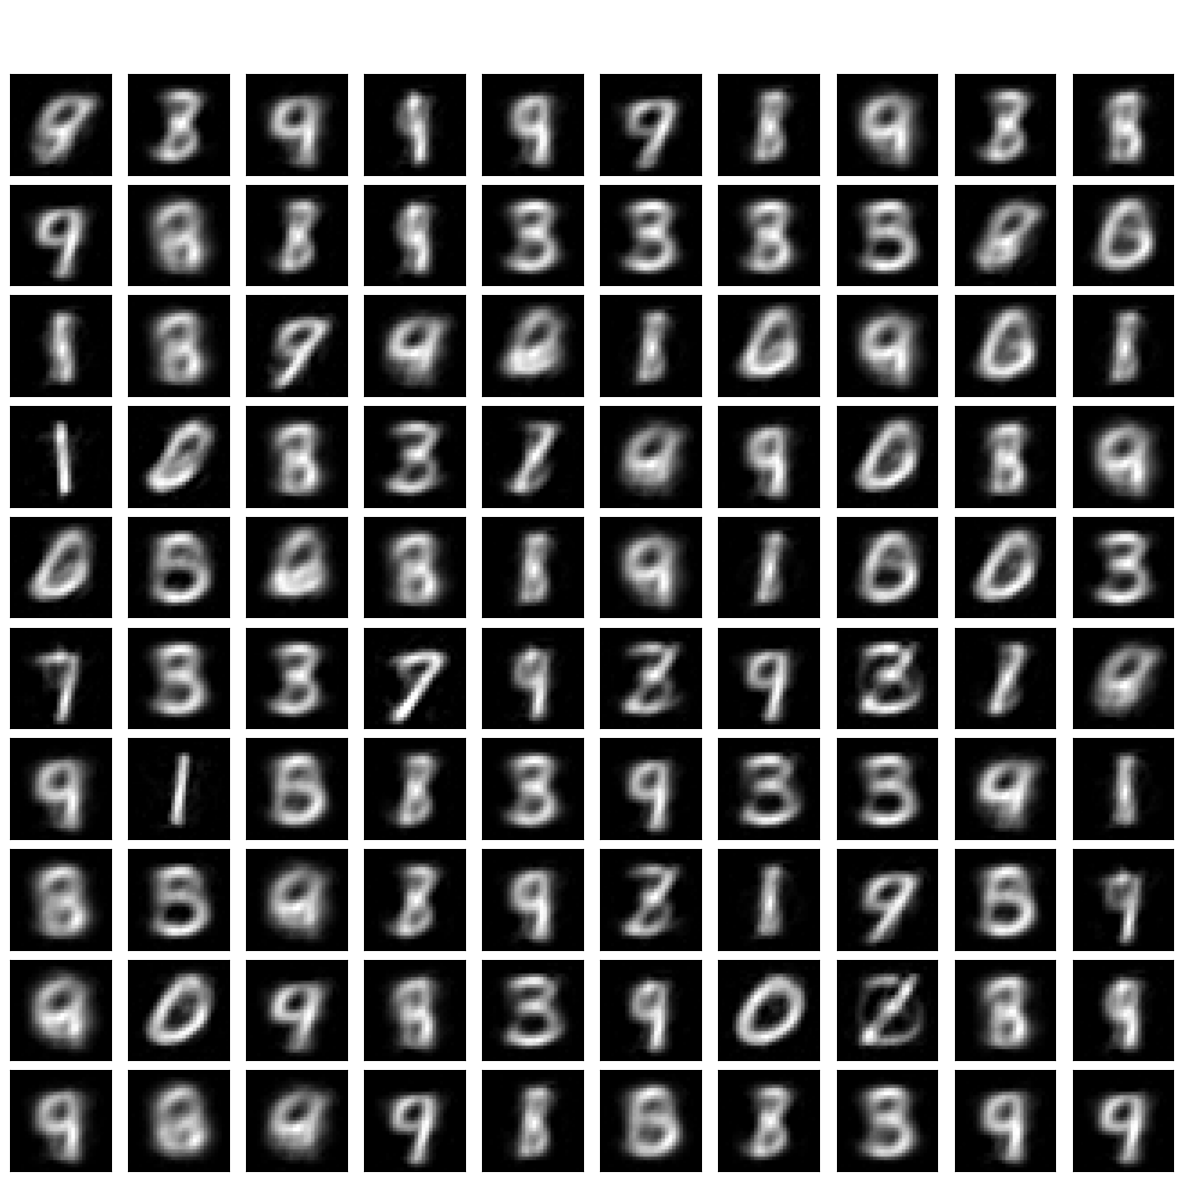

In [22]:
_ = sample_prior(100,dec,mean_data,std_data,device,as_grid=True, color='white')

Using icdf.
z1 range = (-2.326348304748535,2.326348304748535) 
z2 range = (-2.326348304748535,2.326348304748535) 


100%|██████████| 20/20 [00:00<00:00, 37.67it/s]


Using linear steps.
z1 range = (-4.0,4.0) 
z2 range = (-4.0,4.0) 


100%|██████████| 20/20 [00:00<00:00, 37.12it/s]


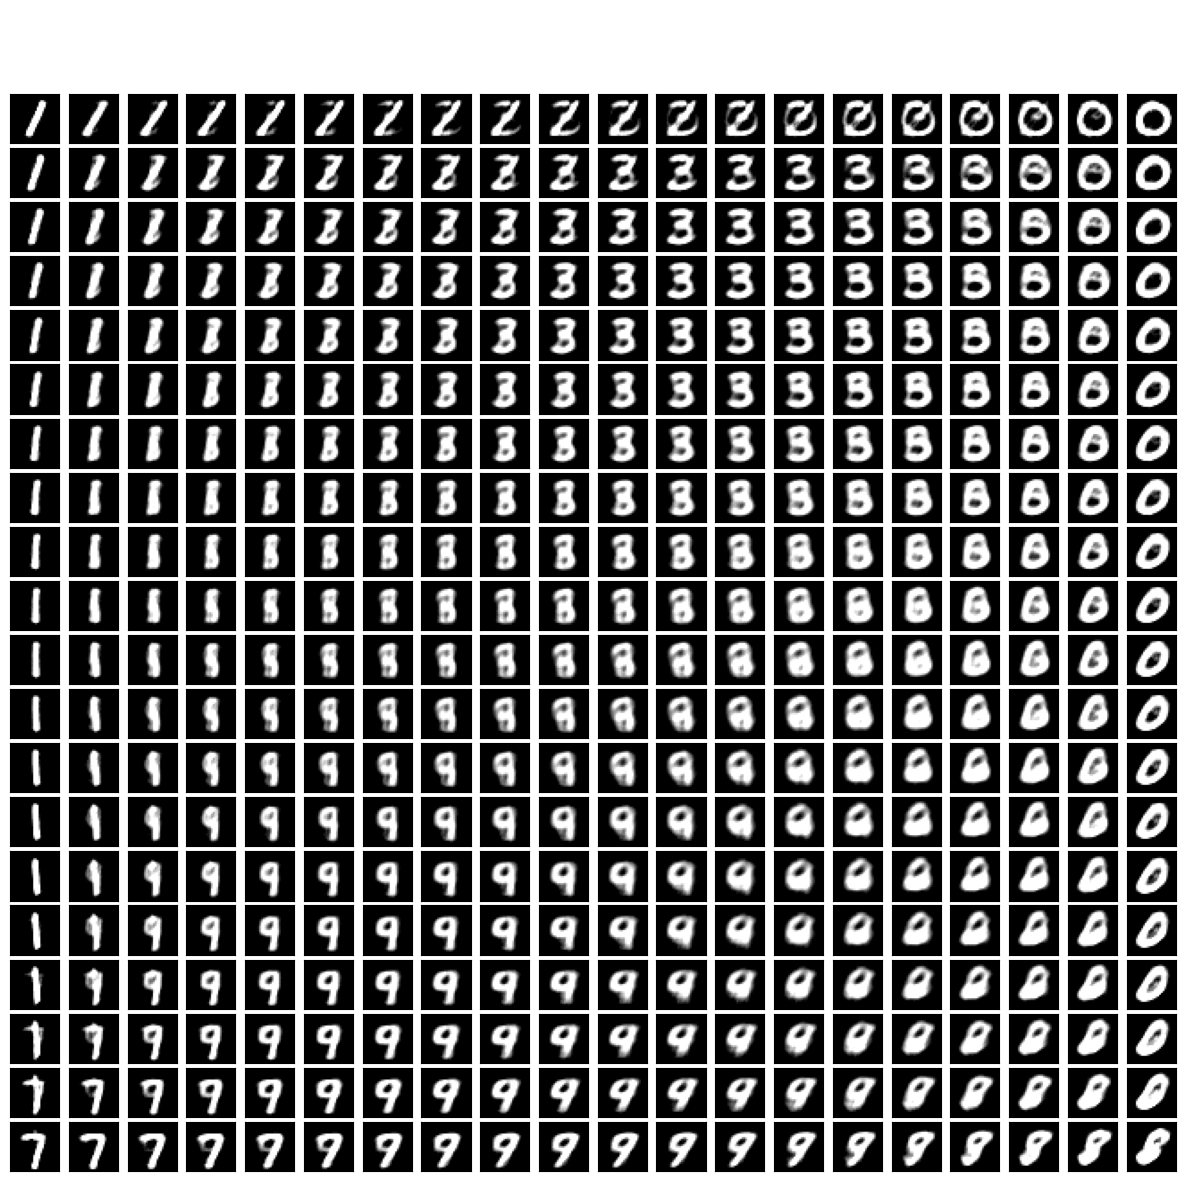

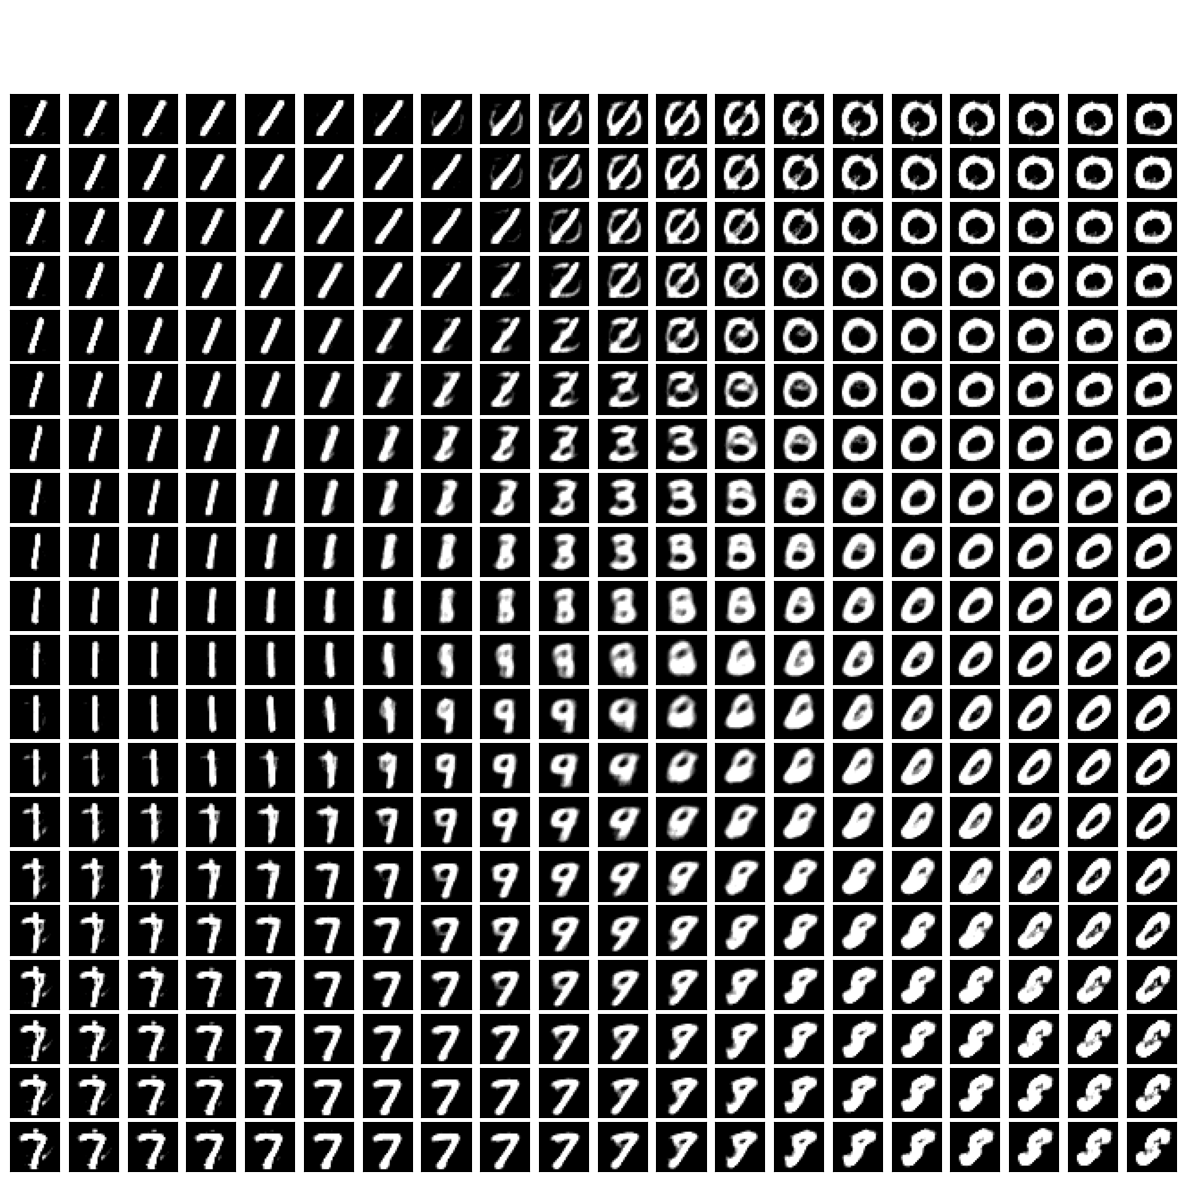

In [23]:
imgs = interpolate(dec, dim, device, probs=(0.01,0.99), WH=None, steps=(20,20), color='white')
imgs = interpolate(dec, dim, device, probs=None, WH=(4.0,4.0), steps=(20,20), color='white')

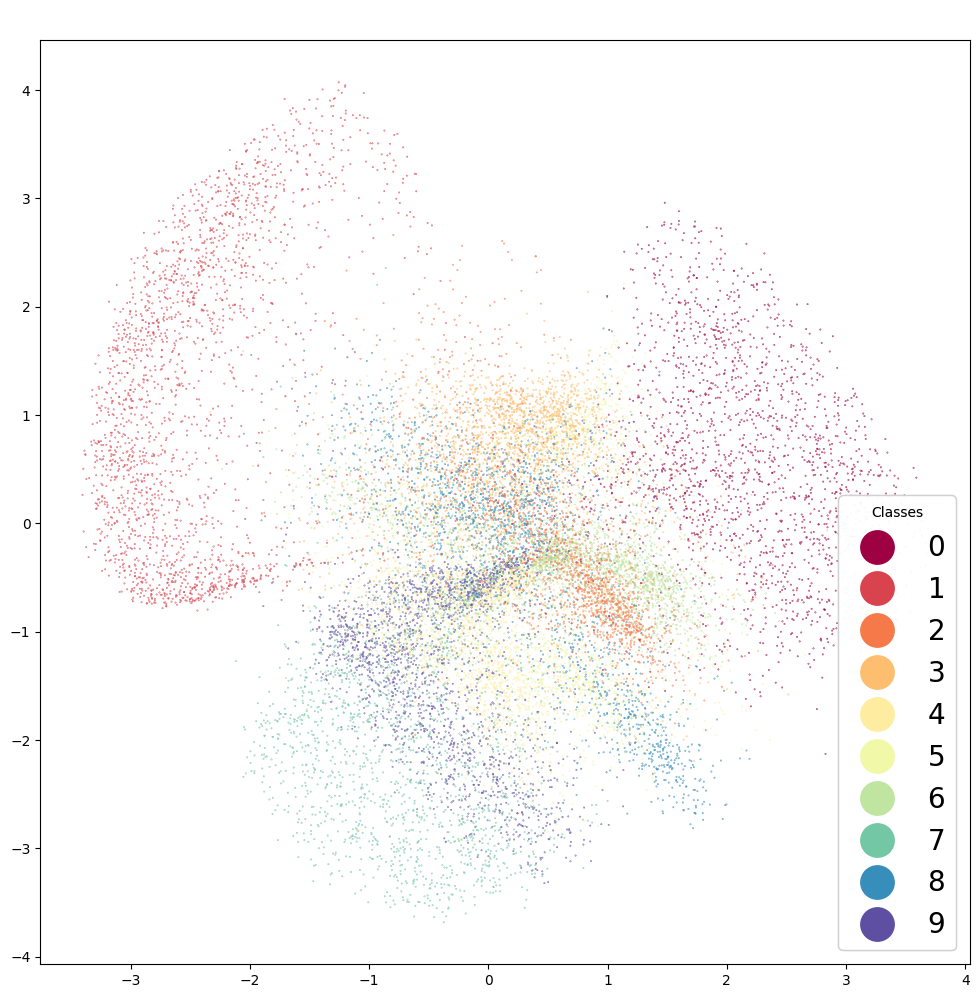

In [24]:
latent_vis(enc, loader, device, mean_data, std_data, ffcv, color='white')